<a href="https://colab.research.google.com/github/algaebrown/cse291spr21/blob/main/assignment2/cse291_assignment2_starter_code_mine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 291 Assignment 2 BiLSTM CRF

## Download Data/Eval Script

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
! cd gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/

In [ ]:

! git pull

error: Your local changes to the following files would be overwritten by merge:
	assignment2/cse291_assignment2_starter_code.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [ ]:
!git add assignment2/cse291_assignment2_starter_code.ipynb
! git commit -m "a2"
! git push

[main 78322da] a2
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite assignment2/cse291_assignment2_starter_code.ipynb (77%)
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!git config --global user.email "hsher@ucsd.edu"
!git config --global user.name "Hsuan-lin Her"


In [ ]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

--2021-05-28 16:28:28--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2021-05-28 16:28:28 (49.4 MB/s) - ‘conlleval.py’ saved [7502/7502]

--2021-05-28 16:28:28--  https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745734 (728K) [text/plain]
S

In [ ]:
import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preparation

In [ ]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield [START_TAG]+sent[0]+[STOP_TAG], [START_TAG]+sent[1]+[STOP_TAG] ##### append start and end tag
                #yield sent[0], sent[1] ##### append start and end tag
                sent = [[], []]




def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])

word_vocab = Vocab(train_word_counter, specials=(UNK, PAD, START_TAG, STOP_TAG), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1)

train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')

valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

Train word vocab: 3949 symbols.
Train label vocab: 10 symbols: ['O', '<start>', '<stop>', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
<start> Pusan 0000 0000 0000 0000 0000 0000 <stop>
<start> I-ORG O O O O O O <stop>
<start> Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north . <stop>
<start> O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O <stop>


In [ ]:
START_TAG_IDX = label_vocab.stoi[START_TAG]
STOP_TAG_IDX = label_vocab.stoi[STOP_TAG]

## BiLSTMTagger

In [ ]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device) # hidden_dim * target_size (8)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence)) # word embedding: 1*7*128
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out) # perform learn Wh+b
        return bilstm_feats

    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1) # return the sum of prob, and labels ([2,0,0,0,0,0,0,])

    def loss(self, sentence, tags):
        bilstm_feats = self.compute_lstm_emission_features(sentence) #1*7*8
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return torch.nn.functional.cross_entropy(
              bilstm_feats.view(-1, self.tagset_size),  # 1*7*8 becomes 7*8
              tags.view(-1), #1*7 becomes 7
              reduction='sum'
            )


## Train / Eval loop

In [ ]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    mean_loss_per_epoch = []
    losses_per_epoch = []
    eval_per_epoch = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device) # sent: sentence in the form of integers, torch.Size[7]; tag the same
            sent = sent.unsqueeze(0) # 1*7
            tags = tags.unsqueeze(0)
            loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                mean_loss = np.mean(losses_per_epoch[-1][-log_interval:])
                print(losses_per_epoch[-1][-log_interval:])
                print(f'Avg loss over last {log_interval} updates: {mean_loss}')
            
        
        _,_,_,eval_result, eval_loss = evaluate(model, valid_data, word_vocab, label_vocab)
        mean_loss_per_epoch.append([mean_loss, eval_loss]) # train and eval loss per epoch
        eval_per_epoch.append(eval_result) # tuple of prec, rec, f1 scores
    return mean_loss_per_epoch, eval_per_epoch


def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]][1:-1]) ## remove <start> <end>
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]][1:-1])
            sents.append([word_vocab.itos[i] for i in sent[0]])
    
    print('Avg evaluation loss:', np.mean(losses))
    result = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    
    
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags, result, np.mean(losses)


## Training

In [ ]:
# Train BiLSTM Tagger Baseline
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epoch_loss, val_perf = train(model, train_data, valid_data, word_vocab, label_vocab, epochs=10, log_interval=500)
loss_df = pd.DataFrame(epoch_loss, columns = ['train_loss', 'valid_loss'])
vals_score = pd.DataFrame(val_perf, columns = ['precision', 'recall', 'F1'])

torch.save(model.state_dict(), 'gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/naive_model_final.pt')

--- EPOCH 0 ---
[66.27485656738281, 53.26569747924805, 24.33085060119629, 20.069490432739258, 16.7303409576416, 18.186260223388672, 12.763596534729004, 11.88485050201416, 10.339533805847168, 15.631326675415039, 18.301660537719727, 18.950336456298828, 35.5619010925293, 5.886392116546631, 73.44757080078125, 13.927355766296387, 55.4251823425293, 81.57038879394531, 33.97072219848633, 68.30326843261719, 71.27936553955078, 9.819984436035156, 17.84158706665039, 7.151381492614746, 4.625269412994385, 2.683323621749878, 8.353350639343262, 40.95758819580078, 82.58658599853516, 6.325904846191406, 6.308383464813232, 42.65691375732422, 8.720229148864746, 27.802425384521484, 8.14515209197998, 13.512541770935059, 3.3657431602478027, 8.28626823425293, 5.233917236328125, 5.594764709472656, 11.507232666015625, 8.166131019592285, 11.987386703491211, 25.765933990478516, 6.126521110534668, 3.3149356842041016, 4.9806060791015625, 2.649061679840088, 9.217747688293457, 14.794960021972656, 3.697801113128662, 7.

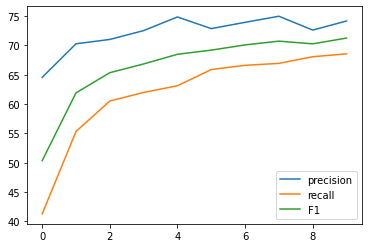

In [ ]:
vals_score.plot()

# RNN CRF
1. need to implement potential functiom for position $t$ that takes the linkear output + U
2.The summed term

In [ ]:
class CRF(nn.Module):
  def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
    super(CRF, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.vocab_size = vocab_size
    self.tagset_size = tag_vocab_size
    
    self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
    self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
    self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device) # hidden_dim * target_size (8)
    self.dropout = nn.Dropout(p=dropout)
    self.weight_matrix=nn.Parameter(torch.randn(self.tagset_size, self.tagset_size, device=device)) # add for the <start> tag and <stop> tag)
    
    self.valid_index = list(set(range(self.tagset_size))-set([STOP_TAG_IDX, START_TAG_IDX])) # exclude start and stop tag
  def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

  def compute_lstm_emission_features(self, sentence):
      hidden = self.init_hidden()
      embeds = self.dropout(self.word_embeds(sentence)) # word embedding: 1*7*128
      bilstm_out, hidden = self.bilstm(embeds, hidden)
      bilstm_out = self.dropout(bilstm_out)
      bilstm_out = bilstm_out
      bilstm_feats = self.tag_projection_layer(bilstm_out) # perform learn Wh+b
      return bilstm_feats

  def potential_function_whole(self, sentences, tags, bilstm_feats):
    ''' return the log phi for a sentence and a tag '''
    
    phi = torch.zeros(1).to(device)
    for t in range(1,sentences.size()[1]-1): ####### to <stop> tag
      
      if t == 1:
        phi += (self.weight_matrix[START_TAG_IDX, tags[0,t]] + bilstm_feats[0,t,tags[0,t]]) # transitiong and emit
      else:
        phi += (self.weight_matrix[tags[0,t-1], tags[0,t]] + bilstm_feats[0,t,tags[0,t]]) # transitiong and emit

    # transition into STOP
    phi += self.weight_matrix[tags[0,-2], STOP_TAG_IDX]
      
    
    return phi
  
  def sum_denom(self, sentences, bilstm_feats):
    ''' dynamic programming to sum up for the denominator 
    sum of all possible Ys phi '''
    
    # entire f
    #print(bilstm_feats.shape)
    
    
    for t in range(1,sentences.size()[1]-1):
      #print(f'at iteration {t}')
      if t == 1:
        forward_scores = (self.weight_matrix[START_TAG_IDX, :] + bilstm_feats[0,t, :])
        
      else:

        new_score = [0]*self.tagset_size
        for tag_n in self.valid_index: # for all allowed middle states
          new_score[tag_n] = torch.logsumexp(
              forward_scores[self.valid_index]+ # previous state
              self.weight_matrix[self.valid_index, tag_n]+ # transitioning from all positnle prev state
              bilstm_feats[0,  t, tag_n].expand(len(self.valid_index)),
              dim = 0 # emitting tag_n at spot t
          )
        # update at the end of each timestep t
        #print(new_score)
        #forward_scores = torch.tensor(new_score).to(device)
        for i in self.valid_index:
          forward_scores[i] = new_score[i]

        
    final_score = torch.logsumexp(
        forward_scores[self.valid_index]+
        self.weight_matrix[self.valid_index, STOP_TAG_IDX], # transitioning from all positnle prev state
        dim = 0
    )
    return final_score
          
  def decode(self, sentences, bilstm_feats):
    
    backtrack = torch.zeros(self.tagset_size, sentences.size()[1])
    
    
    for t in range(1,sentences.size()[1]-1):
      #print(f'creating backtrack to pos {t}')
      if t == 1:
        scores = self.weight_matrix[START_TAG_IDX, :] + bilstm_feats[0,t, :]
        backtrack[:,t] = START_TAG_IDX
      else:

        new_scores = [0]*self.tagset_size
        for tag_n in self.valid_index: # for all allowed middle states
          
          new_scores[tag_n], max_index = torch.max(
              scores[self.valid_index] +
              self.weight_matrix[self.valid_index, tag_n]+ # transitioning from all positnle prev state
              bilstm_feats[0,  t, tag_n].expand(len(self.valid_index)),
              dim = 0 # emitting tag_n at spot t
          )
          backtrack[tag_n, t] = self.valid_index[max_index]
        for i in self.valid_index:
          scores[i] = new_scores[i]
    #print(f'final state to pos {t}')
    final_score, max_index = torch.max(
        scores[self.valid_index]+
        self.weight_matrix[self.valid_index, STOP_TAG_IDX], # transitioning from all positnle prev state
        dim = 0
    )
    backtrack[STOP_TAG_IDX, t+1] = self.valid_index[max_index]


    output_sequence = [STOP_TAG_IDX]
    for t in range(sentences.size()[1]-1, 0, -1):
      current = int(output_sequence[0])
      prev_tag = backtrack[current, t]
      output_sequence = [prev_tag] + output_sequence
      #print(f'from {current} to {prev_tag}')
      
        
      


    return final_score, torch.tensor([int(i) for i in output_sequence]).unsqueeze(0)
  def loss(self, sentences, tags):
    '''calculate NLL for 1 sentence '''
    #print(self.sum_denom(sentences), self.potential_function_whole(sentences, tags))
    bilstm_feats = self.compute_lstm_emission_features(sentences) # entire f
    return  self.sum_denom(sentences, bilstm_feats) - self.potential_function_whole(sentences, tags, bilstm_feats)
  def forward(self, sentences):
    bilstm_feats = self.compute_lstm_emission_features(sentences) # entire f
    return self.decode(sentences, bilstm_feats)
  

In [ ]:
crfm = CRF(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(crfm.parameters(), lr=1e-3)
epoch_loss, val_perf = train(crfm, train_data, valid_data, word_vocab, label_vocab, epochs=10, log_interval=500)
loss_df = pd.DataFrame(epoch_loss, columns = ['train_loss', 'valid_loss'])
vals_score = pd.DataFrame(val_perf, columns = ['precision', 'recall', 'F1'])
torch.save(crfm.state_dict(), 'gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/stupid_model_final.pt')

--- EPOCH 0 ---
[95.07841491699219, 77.41798400878906, 31.18082046508789, 23.14945411682129, 20.72990608215332, 22.732040405273438, 12.410255432128906, 7.3495259284973145, 10.871018409729004, 19.247360229492188, 17.100873947143555, 27.13069725036621, 46.467105865478516, 3.5335774421691895, 119.81327056884766, 15.574063301086426, 97.46636962890625, 134.7902374267578, 43.14868927001953, 88.91451263427734, 127.84722900390625, 11.339298248291016, 25.981739044189453, 8.376618385314941, 2.7109363079071045, 1.7643194198608398, 8.969029426574707, 65.83657836914062, 135.1419677734375, 7.666476726531982, 13.153714179992676, 68.09182739257812, 3.4302010536193848, 53.18178939819336, 10.137298583984375, 17.214553833007812, 0.8074884414672852, 8.2860689163208, 6.8592848777771, 7.399539470672607, 7.271678924560547, 7.359046936035156, 5.682488441467285, 22.5760498046875, 8.946770668029785, 0.2205963134765625, 5.744840621948242, 1.2143720388412476, 8.210042953491211, 16.716188430786133, 3.8084144592285

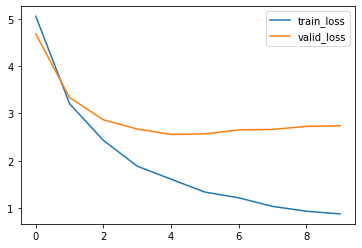

In [ ]:
loss_df.plot()

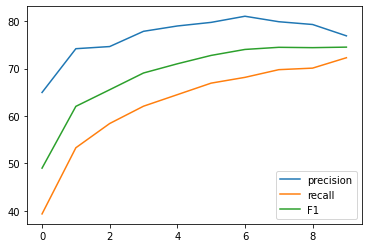

In [ ]:
vals_score.plot()

In [ ]:
crfm = CRF(len(word_vocab), len(label_vocab), 128, 256).to(device)
crfm.load_state_dict(torch.load('gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/stupid_model_final.pt'))



<All keys matched successfully>

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
model.load_state_dict(torch.load('gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/naive_model_final.pt'))

<All keys matched successfully>

In [ ]:
def view_example(index):
  sent, tags = valid_data[index]
  sent = sent.unsqueeze(0)
  tags = tags.unsqueeze(0)
  sent = sent.to(device)
  tags = tags.to(device)
  
  sent_view = [word_vocab.itos[i] for i in sent.tolist()[0]]
  tag_view = [label_vocab.itos[i] for i in tags.tolist()[0]]

  

  ### CRF
  nll, crf_pred = crfm.forward(sent)
  crf_tags = [label_vocab.itos[i] for i in crf_pred.tolist()[0]]

  score, log_pred = model.forward(sent)
  model_tags = [label_vocab.itos[i] for i in log_pred.tolist()[0]]
  df = pd.DataFrame([sent_view, tag_view, crf_tags, model_tags], index = ['sent', 'tag', 'CRF','Baseline'])
  
  return df.replace('<start>', 'START').replace('<stop>', 'STOP').replace('<unk>', 'UNK')
  

In [ ]:
view_example(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sent,START,UNK,-,UNK,Williams,0000,",",UNK,UNK,0000,",",Juan,UNK,0000,STOP
tag,START,I-ORG,O,I-PER,I-PER,O,O,I-PER,I-PER,O,O,I-PER,I-PER,O,STOP
CRF,START,O,O,I-PER,O,O,O,I-PER,I-PER,O,O,I-PER,I-PER,O,STOP
Baseline,START,O,O,I-PER,I-PER,O,O,I-PER,I-PER,O,O,I-PER,I-PER,O,STOP


Text(0.5, 1.0, 'Weight Matrix from CRF')

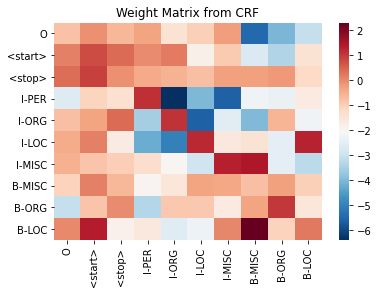

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
lbls = [label_vocab.itos[i] for i in range(crfm.tagset_size)]
sns.heatmap(crfm.weight_matrix.to('cpu').detach().numpy(), xticklabels = lbls, yticklabels = lbls, cmap = 'RdBu_r')
plt.title('Weight Matrix from CRF')

In [ ]:
class CRF_handfeat(nn.Module):
  def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
    super(CRF_handfeat, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.vocab_size = vocab_size
    self.tagset_size = tag_vocab_size
    
    self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
    self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
    self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device) # hidden_dim * target_size (8)
    self.dropout = nn.Dropout(p=dropout)
    self.weight_matrix=nn.Parameter(torch.randn(self.tagset_size, self.tagset_size, device=device)) # add for the <start> tag and <stop> tag)
    self.weight_feat = nn.Parameter(torch.randn(1, device = device))
    self.valid_index = list(set(range(self.tagset_size))-set([STOP_TAG_IDX, START_TAG_IDX])) # exclude start and stop tag
    
  def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

  def compute_lstm_emission_features(self, sentence):
      hidden = self.init_hidden()
      embeds = self.dropout(self.word_embeds(sentence)) # word embedding: 1*7*128
      bilstm_out, hidden = self.bilstm(embeds, hidden)
      bilstm_out = self.dropout(bilstm_out)
      bilstm_out = bilstm_out
      bilstm_feats = self.tag_projection_layer(bilstm_out) # perform learn Wh+b
      return bilstm_feats

  def is_first_word_capital(self, sent_idx):
      word = word_vocab.itos[sent_idx]
      if word[0].isupper():
        return torch.ones(1, device = device)*self.weight_feat
      else:
        return torch.zeros(1, device = device)
  def potential_function_whole(self, sentences, tags, bilstm_feats):
    ''' return the log phi for a sentence and a tag '''
    
    phi = torch.zeros(1).to(device)
    for t in range(1,sentences.size()[1]-1): ####### to <stop> tag
      sent_idx = sentences[0, t]
      if t == 1:
        phi += (self.weight_matrix[START_TAG_IDX, tags[0,t]] + bilstm_feats[0,t,tags[0,t]] + self.is_first_word_capital(sent_idx))
      else:
        phi += (self.weight_matrix[tags[0,t-1], tags[0,t]] + bilstm_feats[0,t,tags[0,t]] + self.is_first_word_capital(sent_idx)) # transitiong and emit

    # transition into STOP
    phi += self.weight_matrix[tags[0,-2], STOP_TAG_IDX]
      
    
    return phi
  
  def sum_denom(self, sentences, bilstm_feats):
    ''' dynamic programming to sum up for the denominator 
    sum of all possible Ys phi '''
    
    # entire f
    #print(bilstm_feats.shape)
    
    
    for t in range(1,sentences.size()[1]-1):
      #print(f'at iteration {t}')
      sent_idx = sentences[0,t]
      if t == 1:
        forward_scores = (
            self.weight_matrix[START_TAG_IDX, :] + 
            bilstm_feats[0,t, :] + 
            self.is_first_word_capital(sent_idx).expand(self.tagset_size)
        )
        
      else:

        new_score = [0]*self.tagset_size
        for tag_n in self.valid_index: # for all allowed middle states
          new_score[tag_n] = torch.logsumexp(
              forward_scores[self.valid_index]+ # previous state
              self.weight_matrix[self.valid_index, tag_n]+ # transitioning from all positnle prev state
              bilstm_feats[0,  t, tag_n].expand(len(self.valid_index))+
              self.is_first_word_capital(sent_idx).expand(len(self.valid_index)),dim = 0) # emitting tag_n at spot t)
        # update at the end of each timestep t
        #print(new_score)
        #forward_scores = torch.tensor(new_score).to(device)
        for i in self.valid_index:
          forward_scores[i] = new_score[i]

        
    final_score = torch.logsumexp(
        forward_scores[self.valid_index]+
        self.weight_matrix[self.valid_index, STOP_TAG_IDX], # transitioning from all positnle prev state
        dim = 0
    )
    return final_score
          
  def decode(self, sentences, bilstm_feats):
    
    backtrack = torch.zeros(self.tagset_size, sentences.size()[1])
    
    
    for t in range(1,sentences.size()[1]-1):
      sent_idx = sentences[0,t]
      #print(f'creating backtrack to pos {t}')
      if t == 1:
        scores = self.weight_matrix[START_TAG_IDX, :] + bilstm_feats[0,t, :]+self.is_first_word_capital(sent_idx).expand(self.tagset_size)

        backtrack[:,t] = START_TAG_IDX
      else:

        new_scores = [0]*self.tagset_size
        for tag_n in self.valid_index: # for all allowed middle states
          new_scores[tag_n], max_index = torch.max(scores[self.valid_index] +
                                                   self.weight_matrix[self.valid_index, tag_n]+ # transitioning from all positnle prev state
                                                   bilstm_feats[0,  t, tag_n].expand(len(self.valid_index)) +
                                                   self.is_first_word_capital(sent_idx).expand(len(self.valid_index)),
                                                   dim = 0 # emitting tag_n at spot t
          )
          backtrack[tag_n, t] = self.valid_index[max_index]
        for i in self.valid_index:
          scores[i] = new_scores[i]
    #print(f'final state to pos {t}')
    final_score, max_index = torch.max(
        scores[self.valid_index]+
        self.weight_matrix[self.valid_index, STOP_TAG_IDX], # transitioning from all positnle prev state
        dim = 0
    )
    backtrack[STOP_TAG_IDX, t+1] = self.valid_index[max_index]


    output_sequence = [STOP_TAG_IDX]
    for t in range(sentences.size()[1]-1, 0, -1):
      current = int(output_sequence[0])
      prev_tag = backtrack[current, t]
      output_sequence = [prev_tag] + output_sequence
      #print(f'from {current} to {prev_tag}')
      
        
      


    return final_score, torch.tensor([int(i) for i in output_sequence]).unsqueeze(0)
  def loss(self, sentences, tags):
    '''calculate NLL for 1 sentence '''
    #print(self.sum_denom(sentences), self.potential_function_whole(sentences, tags))
    bilstm_feats = self.compute_lstm_emission_features(sentences) # entire f
    return  self.sum_denom(sentences, bilstm_feats) - self.potential_function_whole(sentences, tags, bilstm_feats)
  def forward(self, sentences):
    bilstm_feats = self.compute_lstm_emission_features(sentences) # entire f
    return self.decode(sentences, bilstm_feats)
  

In [ ]:
# Train BiLSTM Tagger Baseline
crfm_feat = CRF_handfeat(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(crfm_feat.parameters(), lr=1e-3)
epoch_loss, val_perf = train(crfm_feat, train_data, valid_data, word_vocab, label_vocab, epochs=10, log_interval=500)
loss_df = pd.DataFrame(epoch_loss, columns = ['train_loss', 'valid_loss'])
vals_score = pd.DataFrame(val_perf, columns = ['precision', 'recall', 'F1'])

torch.save(crfm_feat.state_dict(), 'gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/crf_model_feat.pt')

--- EPOCH 0 ---
[75.51874542236328, 63.60932159423828, 24.11241340637207, 17.109527587890625, 17.12343978881836, 17.56020736694336, 9.341906547546387, 5.827483177185059, 5.932746410369873, 12.813787460327148, 9.38344955444336, 21.948484420776367, 36.188507080078125, 1.9042141437530518, 98.92527770996094, 11.152278900146484, 78.23956298828125, 113.97101593017578, 36.17061233520508, 87.21930694580078, 96.4975357055664, 9.88234806060791, 22.212881088256836, 3.124846935272217, 2.1636338233947754, 0.6122581958770752, 6.005300521850586, 53.179866790771484, 113.96086883544922, 2.91168212890625, 7.789621353149414, 64.71107482910156, 4.21684455871582, 36.90260696411133, 7.984962463378906, 18.915992736816406, 0.29052162170410156, 6.2073211669921875, 2.0362348556518555, 1.4161415100097656, 6.047222137451172, 6.322853088378906, 5.900551795959473, 23.26507568359375, 4.446264743804932, 0.05163002014160156, 5.039377689361572, 1.4673818349838257, 8.577993392944336, 14.347919464111328, 1.55003166198730

KeyboardInterrupt: ignored

In [ ]:
torch.ones

<function _VariableFunctionsClass.ones>

In [ ]:
class CRF_handfeat_raw(nn.Module):
  def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
    super(CRF_handfeat_raw, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.vocab_size = vocab_size
    self.tagset_size = tag_vocab_size
    
    self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
    self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
    self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device) # hidden_dim * target_size (8)
    self.dropout = nn.Dropout(p=dropout)
    self.weight_matrix=nn.Parameter(torch.randn(self.tagset_size, self.tagset_size, device=device)) # add for the <start> tag and <stop> tag)
    self.weight_feat = nn.Parameter(torch.randn(1, device = device))
    self.valid_index = list(set(range(self.tagset_size))-set([STOP_TAG_IDX, START_TAG_IDX])) # exclude start and stop tag
    
  def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

  def compute_lstm_emission_features(self, sentence):
      hidden = self.init_hidden()
      embeds = self.dropout(self.word_embeds(sentence)) # word embedding: 1*7*128
      bilstm_out, hidden = self.bilstm(embeds, hidden)
      bilstm_out = self.dropout(bilstm_out)
      bilstm_out = bilstm_out
      bilstm_feats = self.tag_projection_layer(bilstm_out) # perform learn Wh+b
      return bilstm_feats

  
  def potential_function_whole(self, sentences, tags, capvec, bilstm_feats):
    ''' return the log phi for a sentence and a tag '''
    
    phi = torch.zeros(1).to(device)
    for t in range(1,sentences.size()[1]-1): ####### to <stop> tag
      sent_idx = sentences[0, t]
      if t == 1:
        phi += (self.weight_matrix[START_TAG_IDX, tags[0,t]] + bilstm_feats[0,t,tags[0,t]] + self.weight_feat*capvec[0,t])
      else:
        phi += (self.weight_matrix[tags[0,t-1], tags[0,t]] + bilstm_feats[0,t,tags[0,t]] + self.weight_feat*capvec[0,t]) # transitiong and emit

    # transition into STOP
    phi += self.weight_matrix[tags[0,-2], STOP_TAG_IDX]
      
    
    return phi
  
  def sum_denom(self, sentences, capvec, bilstm_feats):
    ''' dynamic programming to sum up for the denominator 
    sum of all possible Ys phi '''
    
    # entire f
    #print(bilstm_feats.shape)
    
    
    for t in range(1,sentences.size()[1]-1):
      #print(f'at iteration {t}')
      sent_idx = sentences[0,t]
      if t == 1:
        forward_scores = (
            self.weight_matrix[START_TAG_IDX, :] + 
            bilstm_feats[0,t, :] + 
            self.weight_feat*capvec[0,t].expand(self.tagset_size)
        )
        
      else:

        new_score = [0]*self.tagset_size
        for tag_n in self.valid_index: # for all allowed middle states
          new_score[tag_n] = torch.logsumexp(
              forward_scores[self.valid_index]+ # previous state
              self.weight_matrix[self.valid_index, tag_n]+ # transitioning from all positnle prev state
              bilstm_feats[0,  t, tag_n].expand(len(self.valid_index))+
              self.weight_feat*capvec[0,t].expand(len(self.valid_index)),dim = 0) # emitting tag_n at spot t)
        # update at the end of each timestep t
        #print(new_score)
        #forward_scores = torch.tensor(new_score).to(device)
        for i in self.valid_index:
          forward_scores[i] = new_score[i]

        
    final_score = torch.logsumexp(
        forward_scores[self.valid_index]+
        self.weight_matrix[self.valid_index, STOP_TAG_IDX], # transitioning from all positnle prev state
        dim = 0
    )
    return final_score
          
  def decode(self, sentences, capvec, bilstm_feats):
    
    backtrack = torch.zeros(self.tagset_size, sentences.size()[1])
    
    
    for t in range(1,sentences.size()[1]-1):
      sent_idx = sentences[0,t]
      #print(f'creating backtrack to pos {t}')
      if t == 1:
        scores = self.weight_matrix[START_TAG_IDX, :] + bilstm_feats[0,t, :]+self.weight_feat*capvec[0,t].expand(self.tagset_size)

        backtrack[:,t] = START_TAG_IDX
      else:

        new_scores = [0]*self.tagset_size
        for tag_n in self.valid_index: # for all allowed middle states
          new_scores[tag_n], max_index = torch.max(scores[self.valid_index] +
                                                   self.weight_matrix[self.valid_index, tag_n]+ # transitioning from all positnle prev state
                                                   bilstm_feats[0,  t, tag_n].expand(len(self.valid_index)) +
                                                   self.weight_feat*capvec[0,t].expand(len(self.valid_index)),
                                                   dim = 0 # emitting tag_n at spot t
          )
          backtrack[tag_n, t] = self.valid_index[max_index]
        for i in self.valid_index:
          scores[i] = new_scores[i]
    #print(f'final state to pos {t}')
    final_score, max_index = torch.max(
        scores[self.valid_index]+
        self.weight_matrix[self.valid_index, STOP_TAG_IDX], # transitioning from all positnle prev state
        dim = 0
    )
    backtrack[STOP_TAG_IDX, t+1] = self.valid_index[max_index]


    output_sequence = [STOP_TAG_IDX]
    for t in range(sentences.size()[1]-1, 0, -1):
      current = int(output_sequence[0])
      prev_tag = backtrack[current, t]
      output_sequence = [prev_tag] + output_sequence
      #print(f'from {current} to {prev_tag}')
      
        
      


    return final_score, torch.tensor([int(i) for i in output_sequence]).unsqueeze(0)
  def loss(self, sentences, capvec, tags):
    '''calculate NLL for 1 sentence '''
    #print(self.sum_denom(sentences), self.potential_function_whole(sentences, tags))
    bilstm_feats = self.compute_lstm_emission_features(sentences) # entire f
    return  self.sum_denom(sentences, capvec, bilstm_feats) - self.potential_function_whole(sentences, tags, capvec, bilstm_feats)
  def forward(self, sentences, capvec):
    bilstm_feats = self.compute_lstm_emission_features(sentences) # entire f
    return self.decode(sentences, capvec, bilstm_feats)
  

In [ ]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield [START_TAG]+sent[0]+[STOP_TAG], [START_TAG]+sent[1]+[STOP_TAG] ##### append start and end tag
                #yield sent[0], sent[1] ##### append start and end tag
                sent = [[], []]




def prepare_dataset_char(dataset, word_vocab, label_vocab):
    dataset = [
      [ 
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
        torch.tensor([int(word[0].isupper()) for word in sent[0]], dtype=torch.long)
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])

word_vocab = Vocab(train_word_counter, specials=(UNK, PAD, START_TAG, STOP_TAG), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1)

train_data_char = prepare_dataset_char(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')

valid_data = list(read_conll_sentence(VALID_DATA))
valid_data_char = prepare_dataset_char(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data_char[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data_char[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data_char[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data_char[1][1]]))


Train word vocab: 3949 symbols.
Train label vocab: 10 symbols: ['O', '<start>', '<stop>', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
<start> Pusan 0000 0000 0000 0000 0000 0000 <stop>
<start> I-ORG O O O O O O <stop>
<start> Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north . <stop>
<start> O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O <stop>


In [ ]:
def train_char(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    mean_loss_per_epoch = []
    losses_per_epoch = []
    eval_per_epoch = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags, capvec) in enumerate(train_data):
            model.zero_grad()
            sent, tags, capvec = sent.to(device), tags.to(device), capvec.to(device) # sent: sentence in the form of integers, torch.Size[7]; tag the same
            sent = sent.unsqueeze(0) # 1*7
            tags = tags.unsqueeze(0)
            capvec = capvec.unsqueeze(0)
            loss = model.loss(sent, capvec, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                mean_loss = np.mean(losses_per_epoch[-1][-log_interval:])
                print(losses_per_epoch[-1][-log_interval:])
                print(f'Avg loss over last {log_interval} updates: {mean_loss}')
            
        
        _,_,_,eval_result, eval_loss = evaluate_char(model, valid_data, word_vocab, label_vocab)
        mean_loss_per_epoch.append([mean_loss, eval_loss]) # train and eval loss per epoch
        eval_per_epoch.append(eval_result) # tuple of prec, rec, f1 scores
    return mean_loss_per_epoch, eval_per_epoch
def evaluate_char(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags, capvec) in enumerate(dataset):
        with torch.no_grad():
            sent, tags, capvec = sent.to(device), tags.to(device), capvec.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            capvec = capvec.unsqueeze(0)
            losses.append(model.loss(sent, capvec, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent, capvec)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]][1:-1]) ## remove <start> <end>
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]][1:-1])
            sents.append([word_vocab.itos[i] for i in sent[0]])
    
    print('Avg evaluation loss:', np.mean(losses))
    result = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    
    
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags, result, np.mean(losses)

In [ ]:
# Train BiLSTM Tagger Baseline
crfm_feat_raw = CRF_handfeat_raw(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(crfm_feat_raw.parameters(), lr=1e-3)
epoch_loss, val_perf = train_char(crfm_feat_raw, train_data_char, valid_data_char, word_vocab, label_vocab, epochs=6, log_interval=500)
loss_df = pd.DataFrame(epoch_loss, columns = ['train_loss', 'valid_loss'])
vals_score = pd.DataFrame(val_perf, columns = ['precision', 'recall', 'F1'])

torch.save(crfm_feat.state_dict(), 'gdrive/MyDrive/cse291_nlp/cse291spr21/assignment2/crf_model_feat_raw.pt')

--- EPOCH 0 ---
[55.563812255859375, 43.278682708740234, 18.373001098632812, 14.7087984085083, 16.089021682739258, 12.309321403503418, 9.241307258605957, 13.471017837524414, 7.227714538574219, 11.270132064819336, 20.56293487548828, 12.88016414642334, 28.683420181274414, 3.232455253601074, 61.06774139404297, 11.16286563873291, 43.3226432800293, 62.21965026855469, 25.477569580078125, 64.82328796386719, 63.6816291809082, 6.715415954589844, 12.07175064086914, 5.700707912445068, 3.0456926822662354, 1.2333405017852783, 7.8235368728637695, 32.7160530090332, 65.37678527832031, 5.419440746307373, 2.8966732025146484, 29.913856506347656, 14.764262199401855, 24.592575073242188, 5.714725494384766, 4.072532653808594, 0.18839454650878906, 9.662614822387695, 5.002654075622559, 5.011394023895264, 12.433708190917969, 5.842235565185547, 16.62186050415039, 30.502593994140625, 5.609006881713867, 0.09320545196533203, 3.6384201049804688, 1.48575758934021, 9.580573081970215, 15.14268970489502, 0.4651660919189

In [ ]:
x=evaluate_char(crfm_feat_raw, valid_data_char, word_vocab, label_vocab)

Avg evaluation loss: 4.3226417656987906
processed 11170 tokens with 1231 phrases; found: 762 phrases; correct: 503.
accuracy:  46.59%; (non-O)
accuracy:  89.07%; precision:  66.01%; recall:  40.86%; FB1:  50.48
              LOC: precision:  81.82%; recall:  47.11%; FB1:  59.79  209
             MISC: precision:  80.00%; recall:  14.58%; FB1:  24.67  35
              ORG: precision:  63.37%; recall:  41.69%; FB1:  50.29  202
              PER: precision:  55.70%; recall:  47.70%; FB1:  51.39  316

5 random evaluation samples:
SENT: <start> 7. <unk> 0000 <stop>
TRUE: O I-ORG O
PRED: I-ORG I-ORG O
SENT: <start> " I think the <unk> <unk> Association should look into this <unk> and deal with it <unk> . <stop>
TRUE: O O O O I-ORG I-ORG I-ORG O O O O O O O O O O O
PRED: O O O O O O O O O O O O O O O O O O
SENT: <start> Net per <unk> ( guilders ) <unk> vs <unk> <stop>
TRUE: O O O O O O O O O
PRED: O I-PER I-PER O I-LOC O O O O
SENT: <start> <unk> <unk> <stop>
TRUE: I-PER I-PER
PRED: O O
SENT: